# Estimation of Price Surfaces

[![Binder](https://notebooks.gesis.org/binder/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/AyrtonB/Merit-Order-Effect/main?filepath=nbs%2Fug-06-surface-estimation.ipynb)

This notebook outlines how to use the `lowess.SmoothDates` model to fit a LOWESS estimate where the coefficients change over time.

<br>

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from moepy import lowess, moe, eda, surface

<br>

### Data Preparation

We'll first load the data in

In [2]:
df_EI = pd.read_csv('../data/ug/electric_insights.csv')

df_EI['local_datetime'] = pd.to_datetime(df_EI['local_datetime'], utc=True)
df_EI = df_EI.set_index('local_datetime')

df_EI.head()

,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00+00:00,32.91,1.0,55.77,55.77,1.1,16268.0,429.0,7.897,0.0,9.902,...,37.948,-0.435,NaN,NaN,0.0,0.0,1.963,0.0,0.0,-0.234
2010-01-01 00:30:00+00:00,33.25,2.0,59.89,59.89,1.1,16432.0,430.0,7.897,0.0,10.074,...,38.227,-0.348,NaN,NaN,0.0,0.0,1.974,0.0,0.0,-0.236
2010-01-01 01:00:00+00:00,32.07,3.0,53.15,53.15,1.1,16318.0,431.0,7.893,0.0,10.049,...,37.898,-0.424,NaN,NaN,0.0,0.0,1.983,0.0,0.0,-0.236
2010-01-01 01:30:00+00:00,31.99,4.0,38.48,38.48,1.1,15768.0,427.0,7.896,0.0,9.673,...,36.918,-0.575,NaN,NaN,0.0,0.0,1.983,0.0,0.0,-0.236
2010-01-01 02:00:00+00:00,31.47,5.0,37.70,37.70,1.1,15250.0,424.0,7.900,0.0,9.370,...,35.961,-0.643,NaN,NaN,0.0,0.0,1.983,0.0,0.0,-0.236


<br>

Then extract the relevant time-series for our analysis

In [3]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

s_dispatchable.head()

local_datetime
2010-01-01 00:00:00+00:00    36.902
2010-01-01 00:30:00+00:00    37.177
2010-01-01 01:00:00+00:00    36.834
2010-01-01 01:30:00+00:00    35.810
2010-01-01 02:00:00+00:00    34.850
dtype: float64

<br>

### Model Fitting

Before we fit our model we need to create an array of dates which will act as the anchor locations of our time-adapative model, at each of these a separate LOWESS curve will be fitted.

In [9]:
reg_dates_start = '2010-01-01'
reg_dates_end = '2021-01-01'
reg_dates_freq = '13W'

reg_dates = pd.date_range(reg_dates_start,  reg_dates_end, freq=reg_dates_freq)

reg_dates[:5]

DatetimeIndex(['2010-01-03', '2010-04-04', '2010-07-04', '2010-10-03',
               '2011-01-02'],
              dtype='datetime64[ns]', freq='13W-SUN')

<br>

We're now ready to fit our model! 

As well as passing in the anchor dates we provide the `dt_idx`, `x`, and `y` arrays from our data. We'll also pass an optional parameter that specifies the number of LOWESS anchor points in the x dimension (reducing the computation required).

In [4]:
smooth_dates = lowess.SmoothDates()

smooth_dates.fit(
    dt_idx=s_dispatchable.index, 
    x=s_dispatchable.values, 
    y=s_price.values, 
    reg_dates=reg_dates, 
    num_fits=15
)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:52<00:00,  3.83s/it]


<br>

As with any `sklearn` style model once we've used `fit` we're ready to `predict`, unlike standard `sklearn` models however we're returned the prediction of the model surface (as a matrix) rather than a single array.

In [5]:
x_pred = np.linspace(8, 60, 521)
dt_pred = pd.date_range('2010-01-01', '2021-01-01')

df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)

df_pred.head()

,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-09,2010-01-10,...,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01
8.0,18.956748,18.966834,18.976896,18.986932,18.996946,19.006940,19.016918,19.026881,19.036833,19.046776,...,5.420775,5.416088,5.411383,5.406662,5.401924,5.397171,5.392403,5.387621,5.382825,5.378016
8.1,19.052351,19.062419,19.072463,19.082482,19.092478,19.102455,19.112415,19.122360,19.132295,19.142220,...,5.667634,5.662972,5.658294,5.653599,5.648888,5.644161,5.639420,5.634665,5.629896,5.625114
8.2,19.147948,19.157999,19.168025,19.178026,19.188004,19.197963,19.207906,19.217834,19.227750,19.237658,...,5.914470,5.909835,5.905182,5.900514,5.895829,5.891129,5.886415,5.881686,5.876945,5.872190
8.3,19.243552,19.253584,19.263593,19.273576,19.283537,19.293478,19.303403,19.313313,19.323212,19.333102,...,6.161549,6.156939,6.152313,6.147671,6.143013,6.138340,6.133652,6.128951,6.124236,6.119508
8.4,19.339173,19.349188,19.359179,19.369145,19.379088,19.389011,19.398918,19.408810,19.418692,19.428564,...,6.409112,6.404529,6.399930,6.395314,6.390682,6.386036,6.381375,6.376700,6.372013,6.367312


<br>

We'll quickly visualise this surface, masking areas where no data was available

C:\Users\Ayrto\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Text(107.08333333333331, 0.5, 'Demand - [Solar + Wind] (GW)')

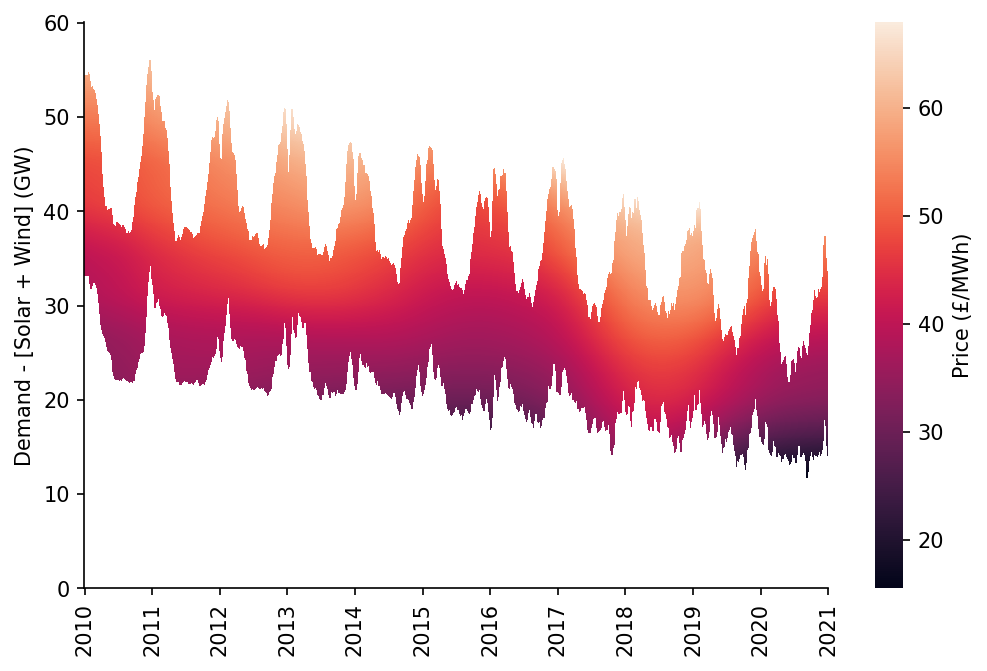

In [6]:
# Preparing mask
df_dispatchable_lims = moe.construct_dispatchable_lims_df(s_dispatchable)
df_pred_mask = moe.construct_pred_mask_df(df_pred, df_dispatchable_lims)

# Plotting
fig, ax = plt.subplots(dpi=150, figsize=(8, 5))

htmp = sns.heatmap(df_pred[10:60].where(df_pred_mask[10:60], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Price (£/MWh)'})

moe.set_ticks(ax, np.arange(0, 70, 10), axis='y')
moe.set_date_ticks(ax, '2010-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
eda.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

<br>

The model is also `pkl` compatible, allowing it to be easily saved for later use

In [7]:
model_fp = '../data/ug/GB_example_model.pkl'

pickle.dump(smooth_dates, open(model_fp, 'wb'))

<br>

A separate function - `surface.fit_models` - provides a highly flexible interface for orchestrating several model fits. The fitted models are saved using the name specified as the key in the `model_definitions` dictionary.

In [8]:
model_definitions = {
    'GB_detailed_example_model': {
        'dt_idx': s_dispatchable.index,
        'x': s_dispatchable.values,
        'y': s_price.values,
        'reg_dates_start': '2020-01-01',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '26W', 
        'frac': 0.3, 
        'num_fits': 10,
        'dates_smoothing_value': 26, 
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': surface.get_fit_kwarg_sets(qs=[0.5])
    }
}

surface.fit_models(model_definitions, '../data/ug')

GB_detailed_example_model: 100%|█████████████████████████████████████████████████████████| 2/2 [01:45<00:00, 52.91s/it]
